**Copied from [LangChain: Chat with Your Data](https://learn.deeplearning.ai/langchain-chat-with-your-data)** Use the short course to learn about RAG. **This is only tested on M1 using python 3.10**.
[source](https://learn.deeplearning.ai/microsoft-semantic-kernel/lesson/1/introduction)
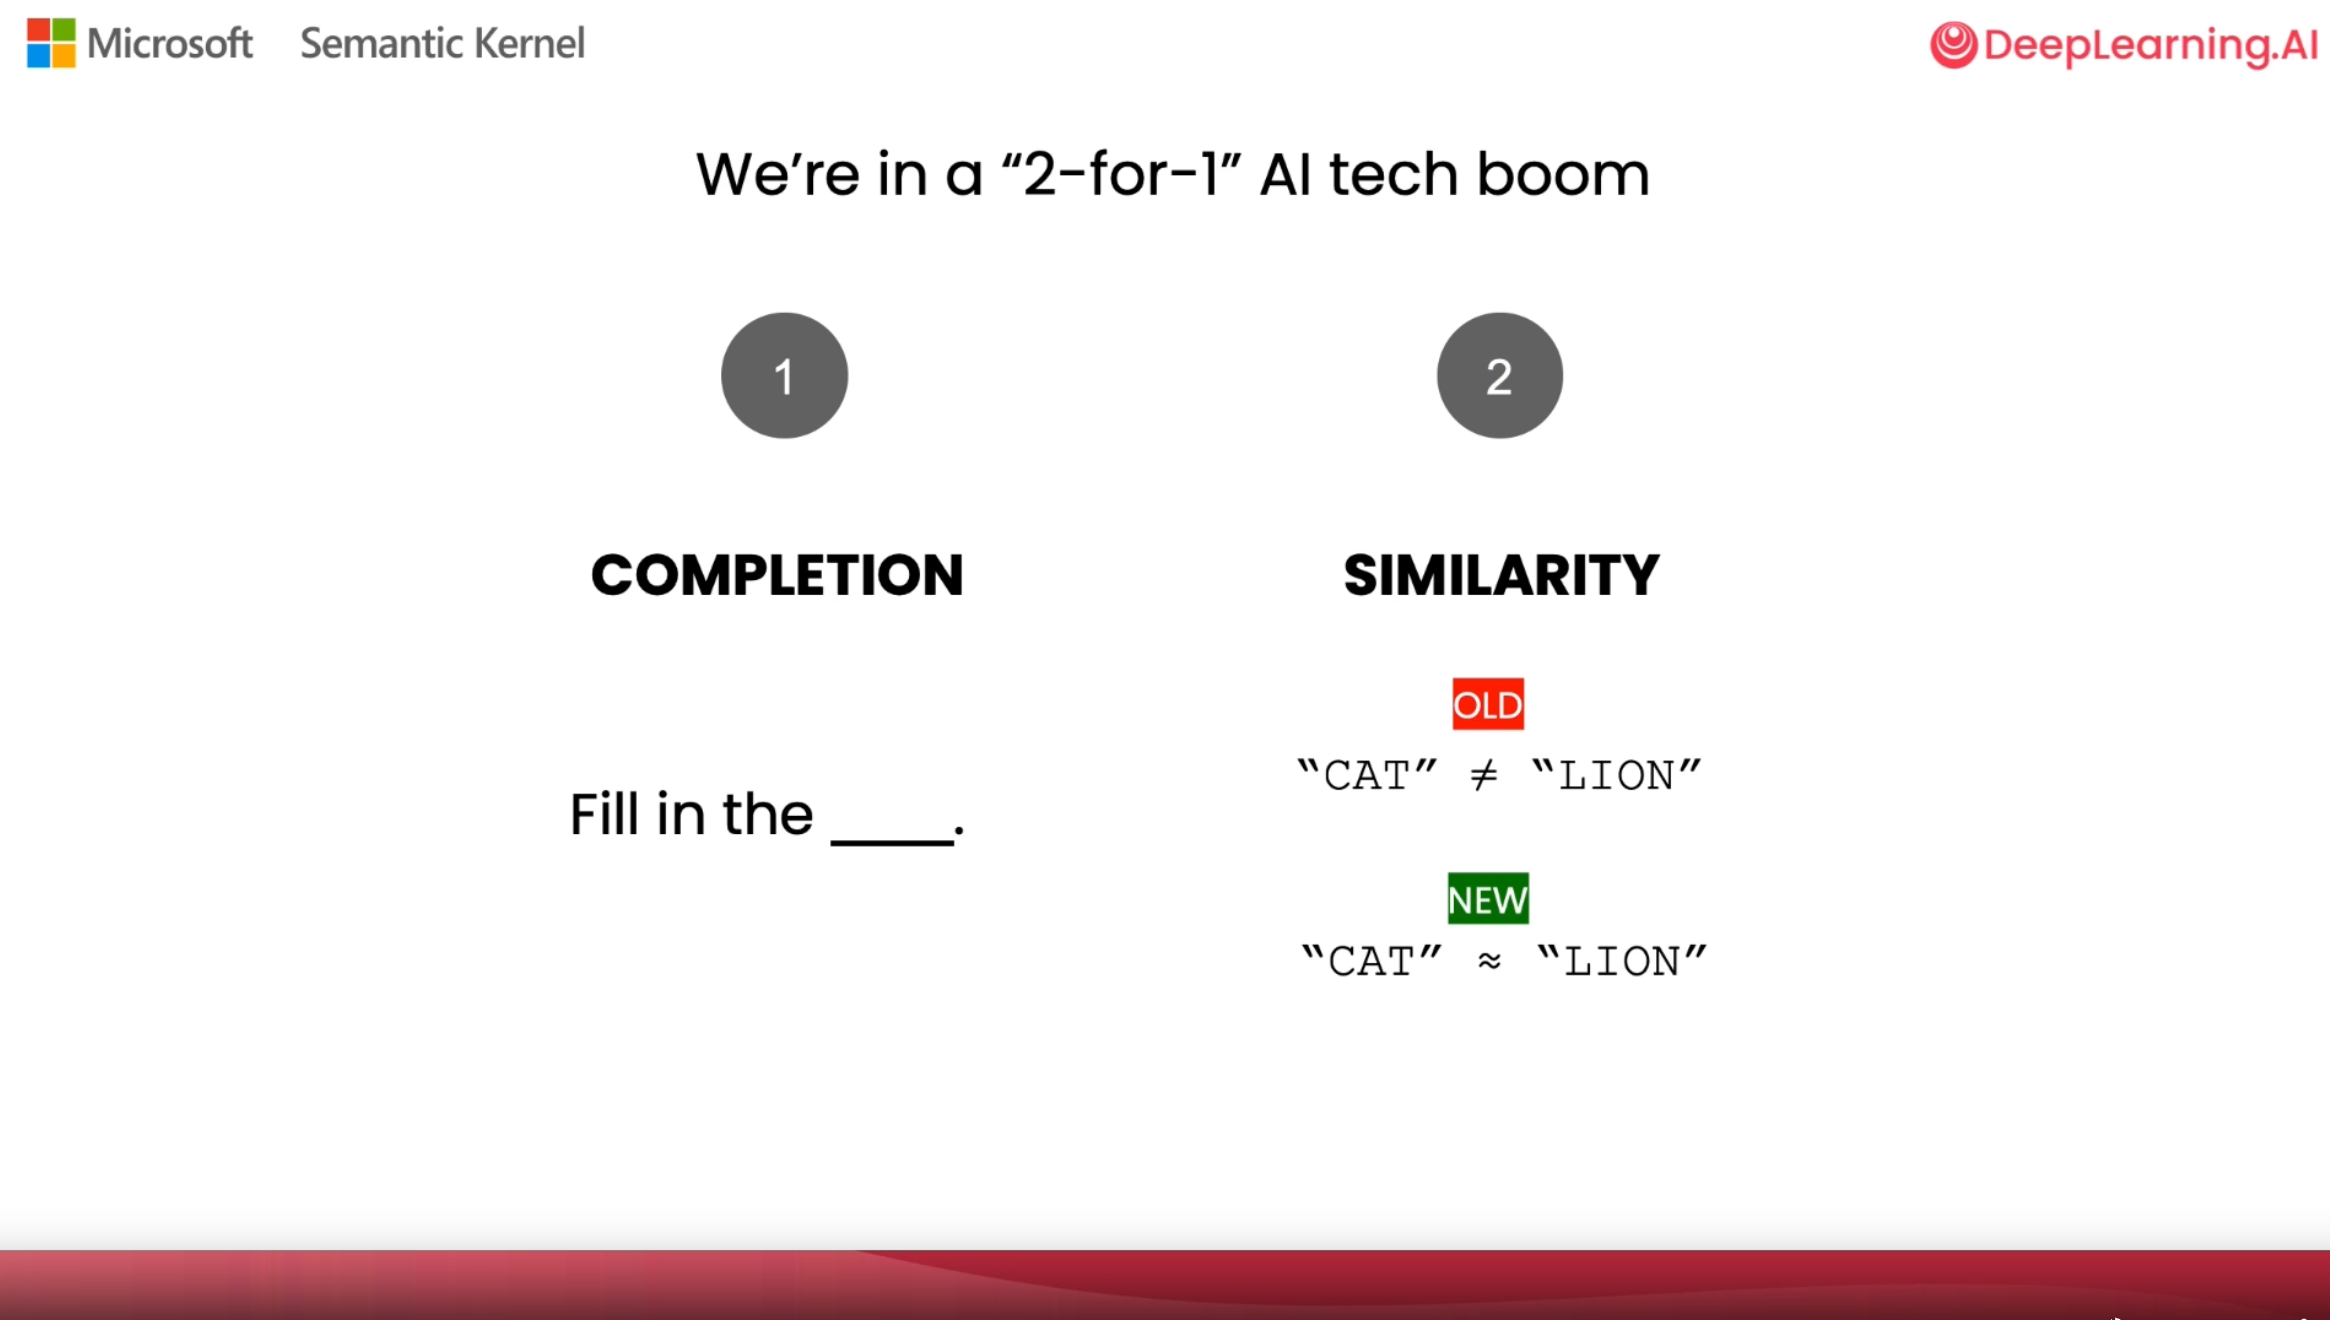

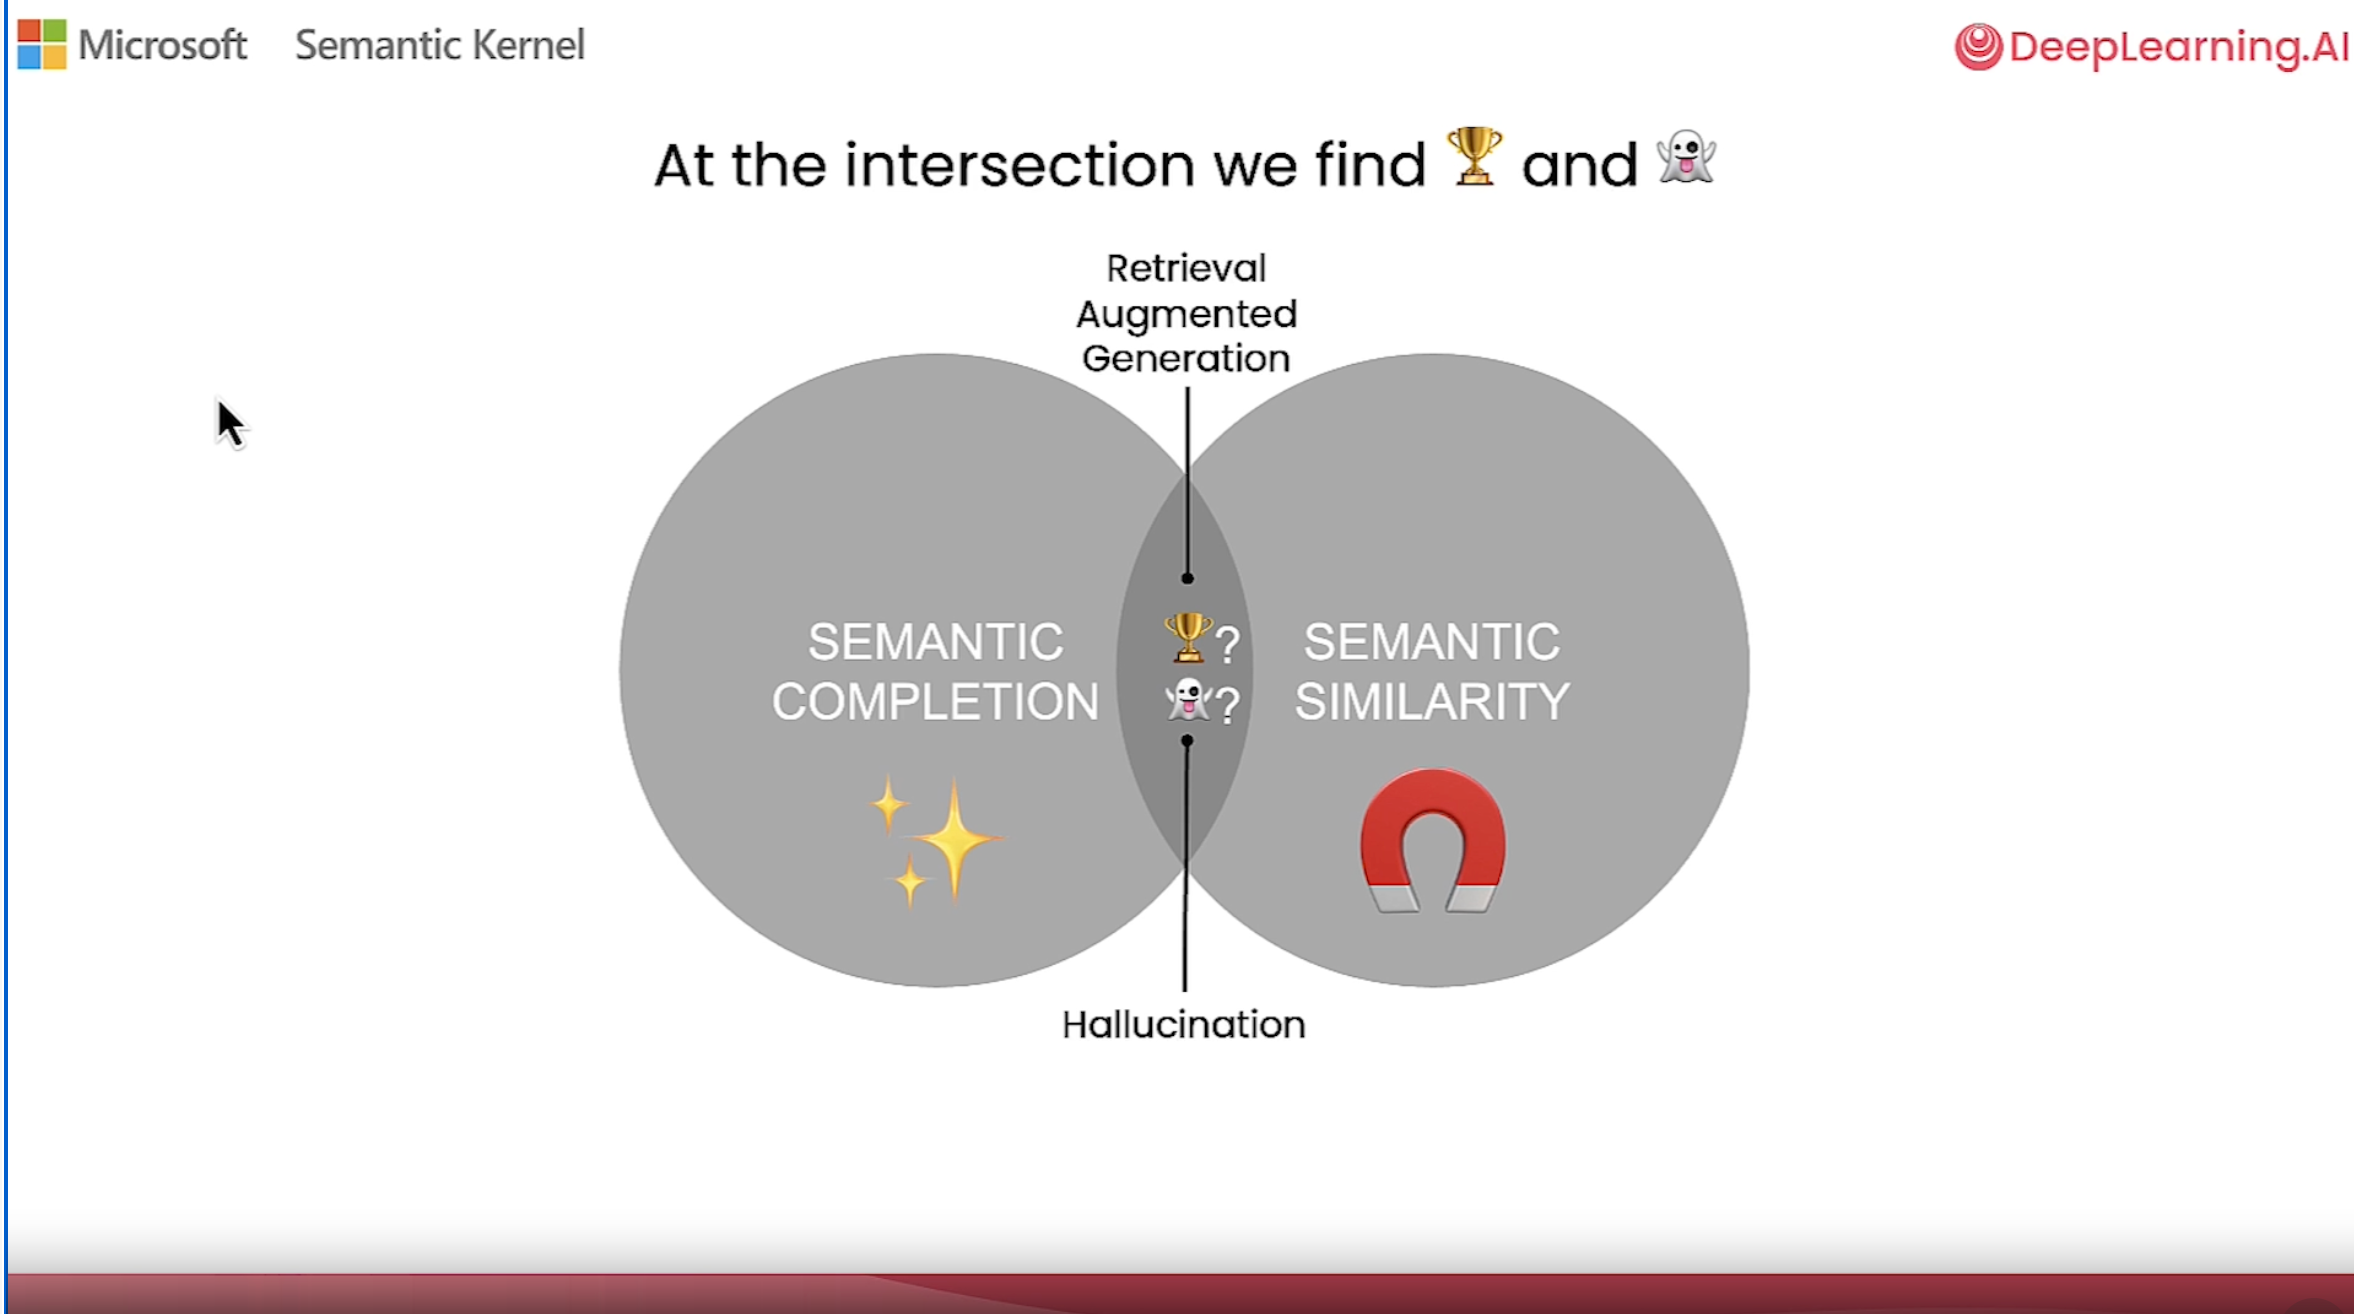

## Retrieval Augmented Generation
 
In retrieval augmented generation (RAG), an LLM retrieves contextual documents from an external dataset as part of its execution.

This is useful if we want to ask question about specific documents (e.g., our PDFs, a set of videos, etc). 


RAG allows Grounding LLMs:
* Access information outside of training data
* Integrate with existing IT systems, databases,
and business data
* Mitigate risk of hallucinations


This notebook uses [langchain](https://python.langchain.com/) and is changed to run offline on local machine.
* Uses [llama.cpp](https://github.com/ggerganov/llama.cpp) as inference engine by running a local openAI API compatible server.
* HuggingFace local embedding

**Code to run with Azure AI is at the bottom**

## Redis  
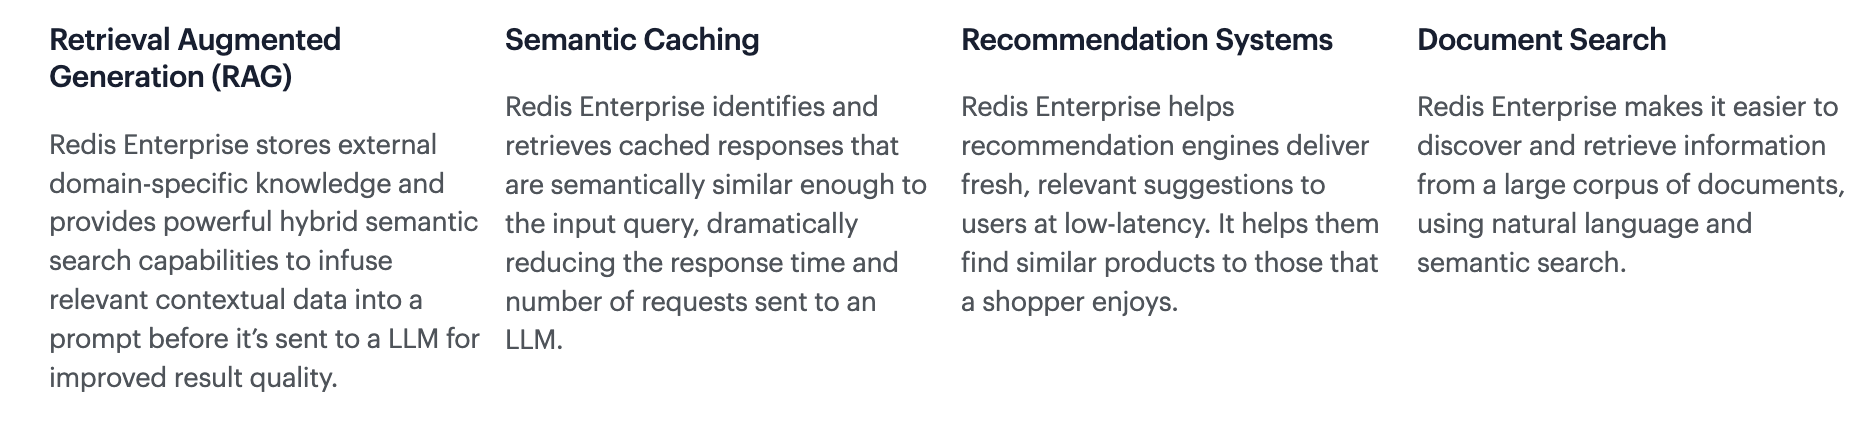

* Retrieving contextual data for RAG using [Redis as a Vector Database](https://python.langchain.com/docs/integrations/vectorstores/redis)
* [Semantic Cache](https://python.langchain.com/docs/integrations/llms/llm_caching#semantic-cache) for prompts based on semantic similarity between the prompt and previously cached results
* [Chat Memory History](https://python.langchain.com/docs/integrations/memory/redis_chat_message_history)



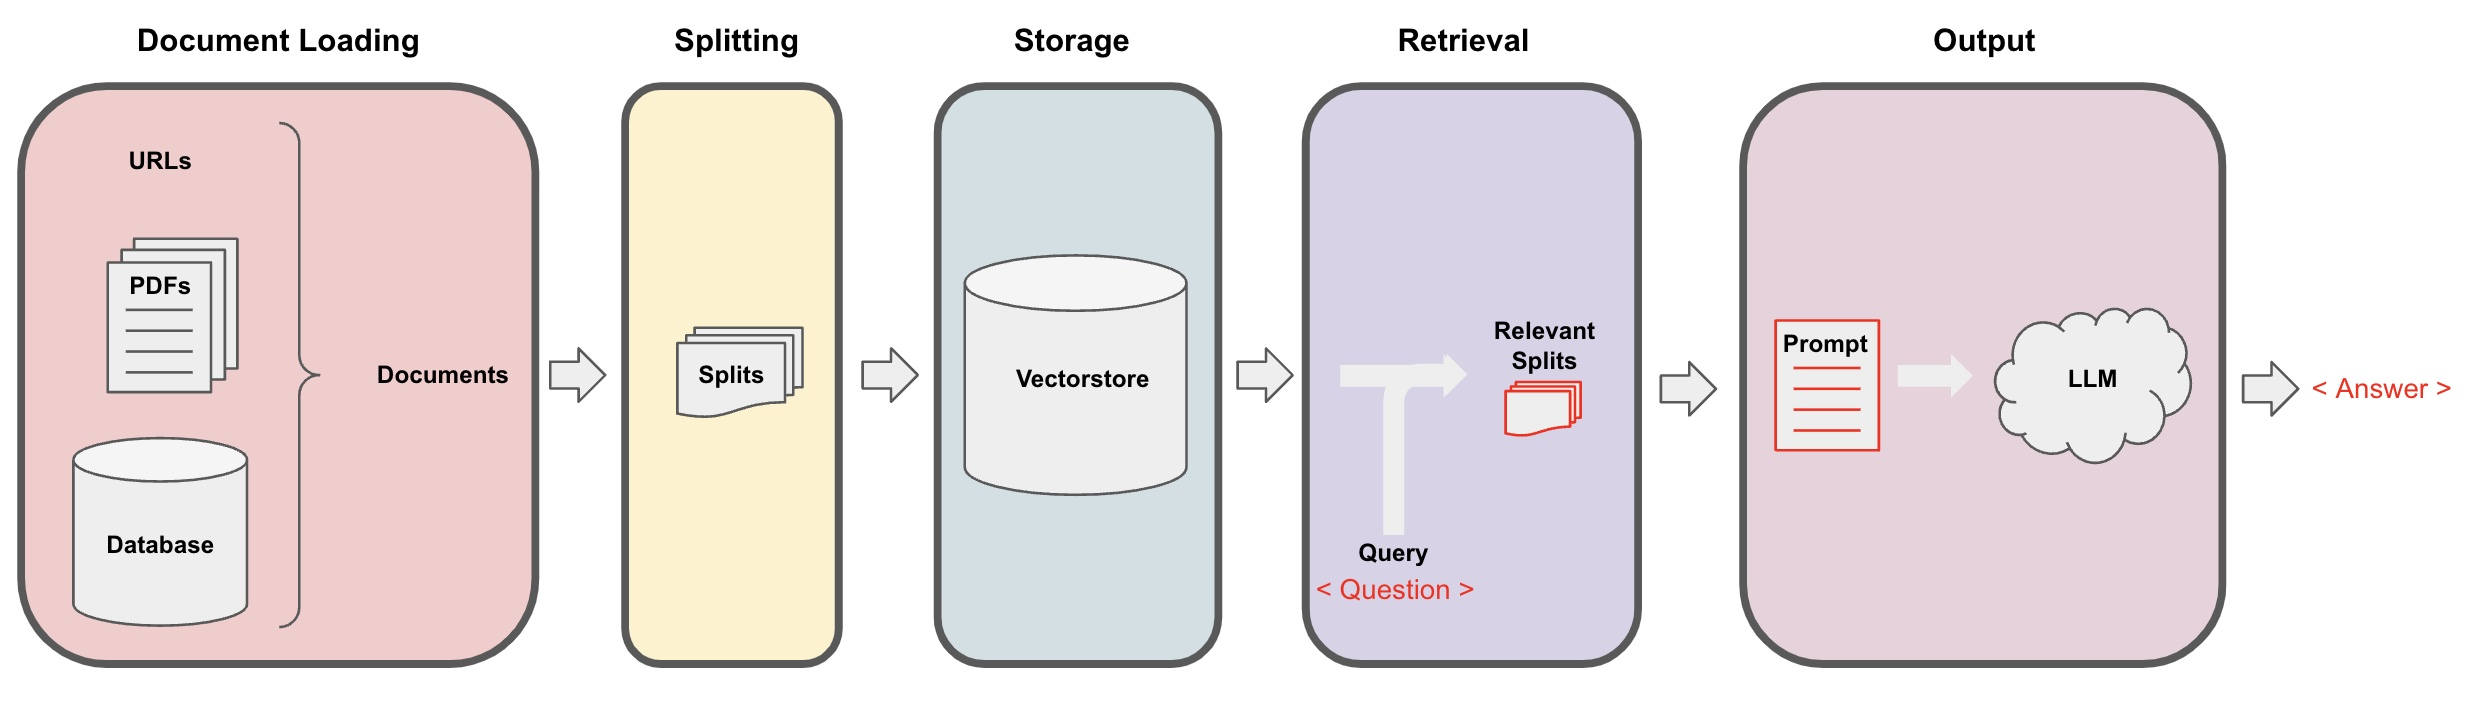

In [1]:
! pip install langchain
! pip install openai
! pip install sentence_transformers
! pip install pypdf
! pip install gradio
! pip install tiktoken
! pip install scikit-learn
! pip install redis

  Obtaining dependency information for langchain from https://files.pythonhosted.org/packages/63/d1/84b1eabf897f2d964b682f55c4fc79e9c81e7367013c816f2f7f00020f5e/langchain-0.0.310-py3-none-any.whl.metadata
  Obtaining dependency information for SQLAlchemy<3,>=1.4 from https://files.pythonhosted.org/packages/ff/b6/fccd627d09045033defba0969b44bb4fc11475846b9ad59f6c5fa5ac23b8/SQLAlchemy-2.0.21-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for aiohttp<4.0.0,>=3.8.3 from https://files.pythonhosted.org/packages/8e/60/5d2a665713ce5f46d9fef626fee5dd4487cbcc3ee6f773706add1f872d92/aiohttp-3.8.6-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for anyio<4.0 from https://files.pythonhosted.org/packages/19/24/44299477fe7dcc9cb58d0a57d5a7588d6af2ff403fdd2d47a246c91a3246/anyio-3.7.1-py3-none-any.whl.metadata
  Using cached anyio-3.7.1-py3-none-any.whl.metadata (4.7 kB)
  Obtaining dependency information for dataclasses-json<0.7,>=0.5.7 from 

In [2]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
import langchain

openai_api_key = "xxxxxx"
openai_api_base ="http://localhost:8081/v1"

temprature_default=0.8
temprature_max=1.0
top_p_default=0.95
top_p_max=1.0
max_tokens_default=256
max_tokens_max=4000

def getLLM(temperature=0.8, top_p=0.95, max_tokens=256):
    return OpenAI(model_name="text-davinci-002", openai_api_base=openai_api_base,
                 openai_api_key= openai_api_key, 
                  max_retries=1,max_tokens=max_tokens,top_p=top_p,temperature=temperature,) #model_kwargs={"top_p":top_p}
    
def getChatLLM(temperature=0.8, top_p=0.95, max_tokens=256):
       return ChatOpenAI(model_name="gpt-3.5-turbo",  
                
                         openai_api_base=openai_api_base,
                 openai_api_key= openai_api_key, max_retries=1,
                 temperature=temperature,max_tokens=max_tokens,model_kwargs={"top_p":top_p} ,) #
def getEmbeddings():
    return HuggingFaceEmbeddings()



# Document Loading

## PDF Document

Let's load a PDF document

In [3]:
from langchain.document_loaders import PyPDFLoader
loaders = [
    PyPDFLoader("docs/Buyers Guide for Enterprise Caching (2022-02).pdf"),
    PyPDFLoader("docs/the-economist- corporate-espionage-is-entering-a-new-era.pdf"),
    PyPDFLoader("docs/How Silicon Valley is helping the Pentagon in the AI arms race _ Financial Times.pdf"),
    PyPDFLoader("docs/2022-chevrolet-colorado-ebrochure.pdf"),
    #PyPDFLoader("docs/kubernetes-docs.pdf"),
    #PyPDFLoader("docs/rc-docs.pdf"),
    #PyPDFLoader("docs/ri-docs.pdf"),
    PyPDFLoader("docs/rs-docs.pdf"),
    #PyPDFLoader("docs/stack-docs.pdf")
]
pages = []
for loader in loaders:
    pages.extend(loader.load())

Each page is a `Document`.

A `Document` contains text (`page_content`) and `metadata`.

In [4]:
import gradio as gr

def pagenumber_change(n):
    page = pages[int(n)]
    return page.page_content,page.metadata

with gr.Blocks() as demopage:
    gr.Markdown("### View Pages")
    page = gr.TextArea(label="Page Content",max_lines=10,value=pages[0].page_content)
    meta_data = gr.Textbox(label="MetaData",value=pages[0].metadata)
    page_number = gr.Slider(label="Page Number",  minimum=0, maximum= len(pages)-1, value=0,step=1, scale=1)
    page_number.release(pagenumber_change, inputs=[page_number], outputs=[page,meta_data])
        
demopage.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


## URLs

In [ ]:
#from langchain.document_loaders import WebBaseLoader

#loader = WebBaseLoader("https://github.com/basecamp/handbook/blob/master/37signals-is-you.md")

In [ ]:
#webdocs = loader.load()

In [ ]:
#print(webdocs[0].page_content[:500])

# Splitting Text

We will use `RecursiveCharacterTextSplitter` and also add lookback period as seperator

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=50,
    separators=["\n\n", "\n", "(?<=\. )", " ", ""],
)

In [7]:
docs = r_splitter.split_documents(pages)

In [8]:
import gradio as gr

def docnumber_change(n):
    doc = docs[int(n)]
    return doc.page_content,doc.metadata

with gr.Blocks() as demodoc:
    gr.Markdown("### View Splitted Documents")
    doc_content = gr.TextArea(label="Document Content",max_lines=10,value=docs[0].page_content)
    doc_meta_data = gr.Textbox(label="MetaData",value=docs[0].metadata)
    doc_number = gr.Slider(label="Document Number",  minimum=0, maximum= len(docs)-1, value=0,step=1, scale=1)
    doc_number.release(docnumber_change, inputs=[doc_number], outputs=[doc_content,doc_meta_data])
        
demodoc.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


# Storage

## Embeddings
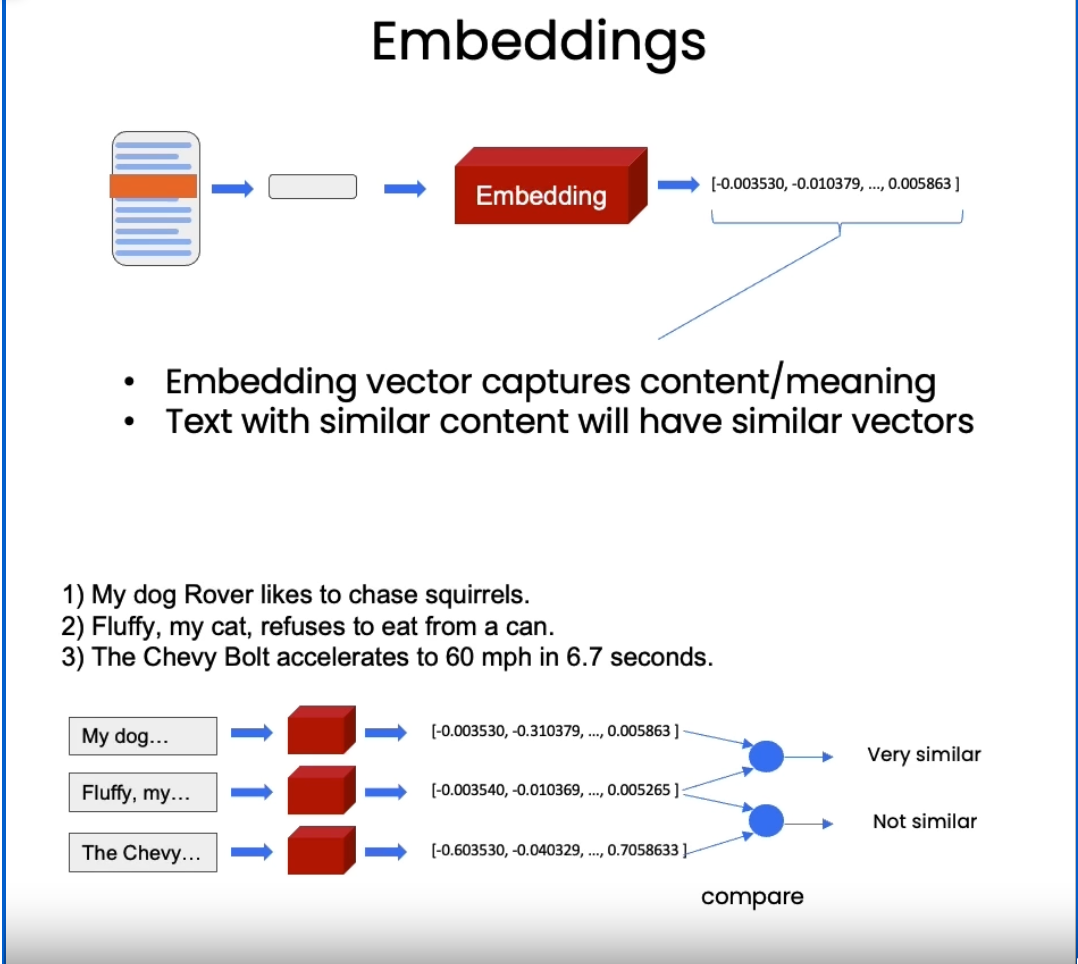

Other uses of embeddings other than similarity are

**Classification**
Train a random forest model to classify the category

**Anomaly / Outlier detection**
We can add an anomalous piece of text and check if the outlier (anomaly) detection algorithm (Isolation Forest) can identify it as an outlier (anomaly), based on its embedding.

In [9]:
from langchain.embeddings import HuggingFaceEmbeddings
from sklearn.metrics.pairwise import cosine_similarity
embedding = getEmbeddings()

In [10]:
sentence1 = "i like dogs"
sentence2 = "i like canines"
sentence3 = "the weather is ugly outside"

In [11]:
embedding1 = embedding.embed_query(sentence1)
embedding2 = embedding.embed_query(sentence2)
embedding3 = embedding.embed_query(sentence3)

In [12]:
import numpy as np

In [13]:
len(embedding1)

768

In [14]:
embedding1[:10]

[-0.013610835187137127,
 0.11503760516643524,
 -0.027678316459059715,
 -0.04148175194859505,
 0.048548173159360886,
 0.038231655955314636,
 -0.04500753805041313,
 -0.012027090415358543,
 -0.002497432753443718,
 -0.01712999865412712]

In [15]:
print(np.dot(embedding1, embedding2))  
print(cosine_similarity([embedding1],[embedding2]))

0.898118277647858
[[0.89811826]]


In [16]:
print(np.dot(embedding1, embedding3))  
print(cosine_similarity([embedding1],[embedding3]))

0.03641027229157741
[[0.03641027]]


In [17]:
print(np.dot(embedding2, embedding3))  
print(cosine_similarity([embedding2],[embedding3]))

0.005847568270677783
[[0.00584757]]


###  Visualizing Embeddings [source](https://learn.deeplearning.ai/google-cloud-vertex-ai/lesson/4/visualizing-embeddings)

#### Embeddings capture meaning

In [18]:
in_1 = "Missing flamingo discovered at swimming pool"
in_2 = "Sea otter spotted on surfboard by beach"
in_3 = "Baby panda enjoys boat ride"

in_4 = "Breakfast themed food truck beloved by all!"
in_5 = "New curry restaurant aims to please!"

in_6 = "Python developers are wonderful people"
in_7 = "TypeScript, C++ or Java? All are great!" 


input_text_lst_news = [in_1, in_2, in_3, in_4, in_5, in_6, in_7]

In [19]:
#Get embeddings for all pieces of text.
embeddings = []
for input_text in input_text_lst_news:
    emb = embedding.embed_query(input_text)
    embeddings.append(emb)
    
embeddings_array = np.array(embeddings) 

In [20]:
print("Shape: " + str(embeddings_array.shape))
print(embeddings_array)

Shape: (7, 768)
[[ 0.01493028 -0.0033108  -0.02366722 ...  0.04382877 -0.00961947
   0.05507185]
 [ 0.02796176  0.05552797 -0.02646971 ...  0.04219675  0.0204251
   0.02744673]
 [-0.00396619  0.05514322 -0.01845468 ...  0.03014262  0.00855401
   0.01467847]
 ...
 [-0.00106714  0.07917717 -0.03888066 ...  0.04137968 -0.01599876
  -0.03126543]
 [ 0.0233445   0.0330693  -0.0190676  ...  0.00999068  0.0809968
  -0.03875097]
 [-0.0049816   0.02441755 -0.04796157 ...  0.00601144  0.06272527
  -0.01878868]]


#### Reduce embeddings from 768/1536 to 2 dimensions for visualization
- We'll use principal component analysis (PCA).
- You can learn more about PCA in [this video](https://www.coursera.org/learn/unsupervised-learning-recommenders-reinforcement-learning/lecture/73zWO/reducing-the-number-of-features-optional) from the Machine Learning Specialization. 

In [21]:
from sklearn.decomposition import PCA

# Perform PCA for 2D visualization
PCA_model = PCA(n_components = 2)
PCA_model.fit(embeddings_array)
new_values = PCA_model.transform(embeddings_array)

In [22]:
print("Shape: " + str(new_values.shape))
print(new_values)

Shape: (7, 2)
[[ 0.5822739  -0.06701153]
 [ 0.598726   -0.10793867]
 [ 0.31289844  0.0043634 ]
 [-0.29369917  0.58462128]
 [-0.29095154  0.56312823]
 [-0.32457285 -0.51324929]
 [-0.58467478 -0.46391342]]


In [23]:
! pip install matplotlib
! pip install mplcursors
! pip install ipympl

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached mplcursors-0.5.2-py3-none-any.whl


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached ipympl-0.9.3-py2.py3-none-any.whl (511 kB)


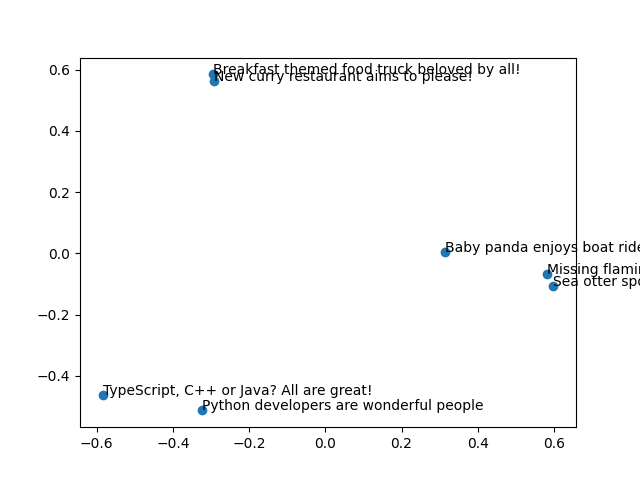

In [24]:
import matplotlib.pyplot as plt
import mplcursors
%matplotlib ipympl

#plt.plot(new_values[:,0], new_values[:,1], 'o')
fig, ax = plt.subplots()
ax.scatter(new_values[:,0], new_values[:,1])
for i, txt in enumerate(input_text_lst_news):
    ax.annotate(txt, (new_values[:,0][i], new_values[:,1][i]))

plt.show()
#from utils import plot_2D
#plot_2D(new_values[:,0], new_values[:,1], input_text_lst_news)

## Vector Stores
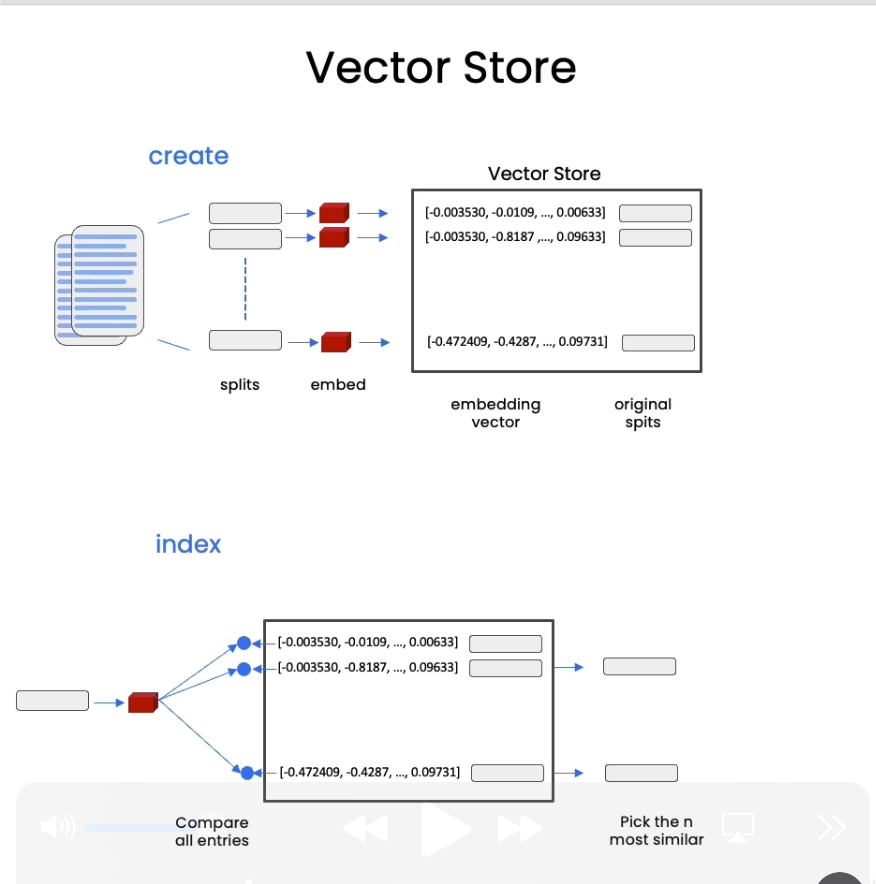
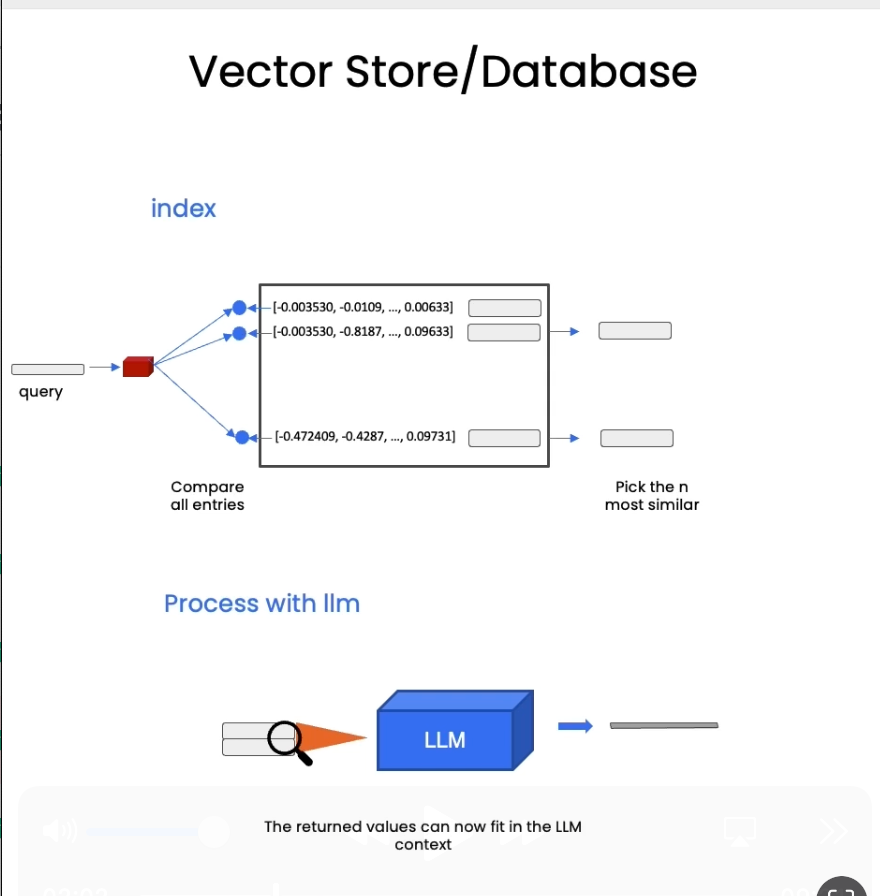

In [25]:
redis_url = "redis://localhost:6379"
index_name = "docs"

In [26]:
from langchain.vectorstores.redis import Redis as RedisVectorStore
from langchain.embeddings import HuggingFaceEmbeddings

In [27]:
vectordb = RedisVectorStore.from_documents(documents=docs,
                                embedding=getEmbeddings(),
                                index_name=index_name,
                                redis_url=redis_url)

# Retrieval

## Similarity Search

In [30]:
#question = "What is redis"
#vectordb.max_marginal_relevance_search(question,k=2,fetch_k=3)

In [31]:
import gradio as gr

def similaritySearch(question, k): 
    #result= vectordb.similarity_search(question,k=int(k))
    result= vectordb.similarity_search(question,k=int(k),fetch_k=int(k) +1 )
    return "\n\n".join(str(x) for x in result)


with gr.Blocks() as demosearch:
    documents = gr.TextArea(label="Documents", max_lines=20)
    with gr.Row():
        search = gr.Textbox(label="Search",scale=5)
        k = gr.Number(label="# of Results", maximum=100, minimum=1, value=3,scale=1)
    with gr.Row():
         gr.Examples([['What is a good cache?'],["What are the minimum requirements to install redis enterprise?"],
                      ["What are the main differences between the three engine types available for the Chevy Colorado?"]],
                     [search],label="Example Searches",)
    with gr.Row():
        searchBtn = gr.Button("Search")
        clearButton = gr.ClearButton(components=[documents,search], value="Clear")
    search.submit(similaritySearch, inputs=[search, k],outputs=documents)
    searchBtn.click(similaritySearch, inputs=[search, k],outputs=documents)
    
gr.close_all()
demosearch.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


# Question Answering

## LLM Model

## Add Redis Semantic Cache for prompts
Semantic caching allows users to retrieve cached prompts based on semantic similarity between the user input and previously cached results. Under the hood it blends Redis as both a cache and a vectorstore.

In [32]:
from langchain.cache import RedisSemanticCache
from langchain.embeddings import HuggingFaceEmbeddings
import langchain

langchain.llm_cache = RedisSemanticCache(
    embedding=getEmbeddings(),
    redis_url=redis_url
)

In [34]:
import gradio as gr
from time import perf_counter_ns

prompt_template = """{prompt}"""

def askLLM(prompt, temperature, top_p,max_tokens):
    start = perf_counter_ns()
    
    llm = getLLM(temperature, top_p, max_tokens)
    completion= llm(prompt_template.format(prompt=prompt))
    
    stop = perf_counter_ns()
    elapasedTime= (stop - start) * 0.000001
    
    return completion, elapasedTime
 
#def clearCache():
#    langchain.llm_cache.clear()
    
with gr.Blocks() as demollm:
    with gr.Row():
        completion = gr.TextArea(label="Completion")
    with gr.Row():
        execution_time =gr.Textbox(label="Execution Time(ms)", scale=1)
        prompt = gr.Textbox(label="Prompt",scale=5, lines=3)
    with gr.Row():
        with gr.Column(scale=1):
            temperature = gr.Slider(label="temperature", maximum=temprature_max, minimum=0, value=temprature_default,step=0.1,scale=1)
            top_p = gr.Slider(label="top_p", maximum=top_p_max, minimum=0, value=top_p_default,step=0.05, scale=1)
            max_tokens = gr.Slider(label="max_tokens", maximum=max_tokens_max, minimum=-1, value=max_tokens_default, step=10, scale=3)
        with gr.Column(scale=2):
            gr.Examples([['When should I use Redis?'],["What is Redis?"],
                      ["Argue that earth is flat"],["What is the meaning of life"]],
                     [prompt],label="Example Prompts",)
            
    with gr.Row():
        askButton = gr.Button("Submit")
        clearButton = gr.ClearButton(components=[completion,prompt,execution_time],value="Clear")
 
    prompt.submit(askLLM, inputs=[prompt, temperature, top_p,max_tokens],outputs=[completion,execution_time])
    askButton.click(askLLM,  inputs=[prompt, temperature, top_p,max_tokens],outputs=[completion, execution_time])

    
gr.close_all()
demollm.launch()

Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


## Chat LLM Model

## Run Chain
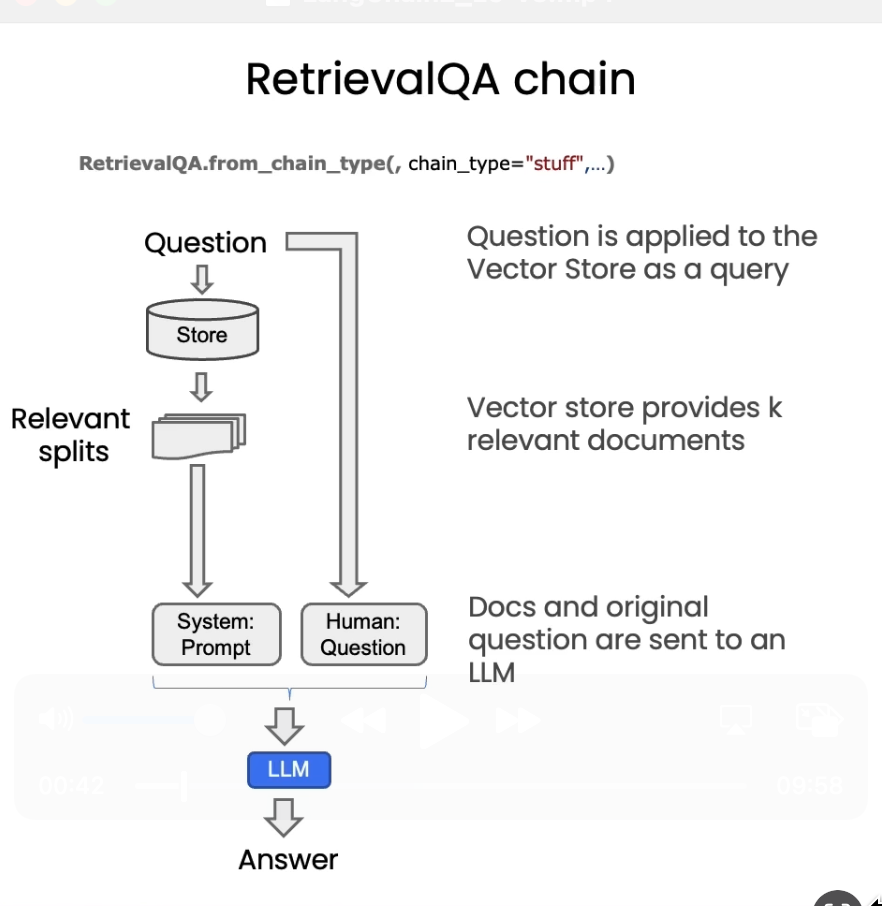

## Prompt

In [35]:
from langchain.prompts import PromptTemplate

# Build prompt
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

In [42]:
from langchain.chains import RetrievalQA
import gradio as gr

def askLLMQA(prompt,temperature, top_p,max_tokens): 
    qa_chain = RetrievalQA.from_chain_type(
        getChatLLM(temperature, top_p,max_tokens), 
        #retriever=vectordb.as_retriever(),
        retriever = vectordb.as_retriever(search_type="similarity_distance_threshold", search_kwargs={"k": 4, "distance_threshold": 0.4}),
        return_source_documents=True,
        chain_type_kwargs={"prompt": QA_CHAIN_PROMPT},
        verbose=True,)
    result = qa_chain({"query": prompt})
    return result["result"], result["source_documents"]


with gr.Blocks() as demoRetrievalQA:
    with gr.Tab("RAG"):
        completion = gr.TextArea(label="Completion")
        with gr.Row() as row:
            prompt = gr.Textbox(label="Prompt",scale=5)
        with gr.Row() as row:
            with gr.Column(scale=1):
                temperature = gr.Slider(label="temperature", maximum=temprature_max, minimum=0, value=temprature_default,step=0.05,scale=1)
                top_p = gr.Slider(label="top_p", maximum=top_p_max, minimum=0, value=top_p_default,step=0.05, scale=1)
                max_tokens = gr.Slider(label="max_tokens", maximum=max_tokens_max, minimum=-1, value=max_tokens_default, step=10, scale=1)
            with gr.Column(scale=2):
                gr.Examples([['What are the minimum requirements to install redis Enterprise?'],["What is a good cache?"],
                      ["What are the main differences between the three engine types available for the Chevy Colorado?"]],
                     [prompt],label="Example Prompts",)

        with gr.Row() as row:
            askBtn = gr.Button("Submit")
    with gr.Tab("Source Documents"):
        with gr.Row() as row:
            documents = gr.TextArea(label="Source Documents")
    prompt.submit(askLLMQA, inputs=[prompt, temperature, top_p,max_tokens],outputs=[completion,documents])
    askBtn.click(askLLMQA,  inputs=[prompt, temperature, top_p,max_tokens],outputs=[completion,documents])
    clearButton = gr.ClearButton(components=[completion,prompt, documents], value="Clear")
             
gr.close_all()
demoRetrievalQA.launch()

Running on local URL:  http://127.0.0.1:7870

To create a public link, set `share=True` in `launch()`.




> Entering new RetrievalQA chain...

> Finished chain.


## Add Redis Chat Memory
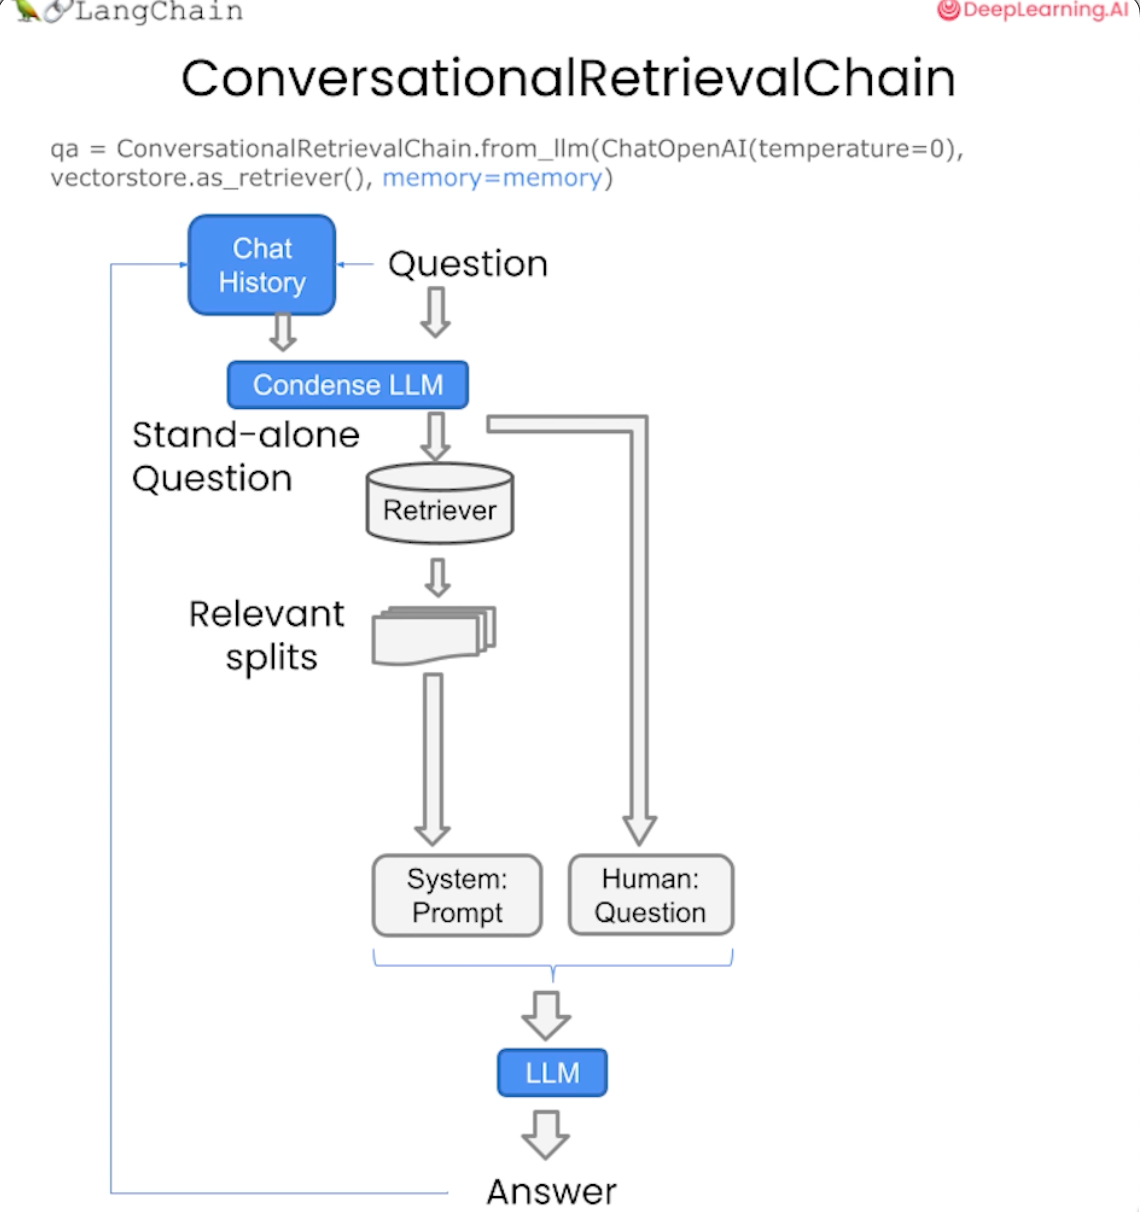

In [37]:
from langchain.memory import ConversationBufferMemory
from langchain.memory.chat_memory import ChatMessageHistory
from langchain.memory.chat_message_histories import RedisChatMessageHistory
message_history = RedisChatMessageHistory(url=redis_url, ttl=600, session_id="session-message")

#  see Memory not working with document sources chain? workaround https://github.com/langchain-ai/langchain/issues/2256
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True,
    input_key="question", output_key="answer",
    chat_memory=message_history
)

## Application

In [50]:
#langchain.llm_cache = None
import gradio as gr
from langchain.chains import ConversationalRetrievalChain

def respond(message, chat_history,temperature, top_p,max_tokens):
    qa = ConversationalRetrievalChain.from_llm(
        getChatLLM(temperature, top_p,max_tokens),
        #retriever=vectordb.as_retriever(),
        retriever = vectordb.as_retriever(search_type="similarity_distance_threshold", search_kwargs={"k": 4, "distance_threshold": 0.4}),
        return_source_documents=True,
        memory=memory,
        verbose=True,
    )
    result  = qa({"question": message})
    completion = result['answer']
    chat_history.append((message, completion))
    return "", chat_history, memory.chat_memory.messages,result["source_documents"]

def clearmemory():
    memory.clear()


with gr.Blocks() as demo:
    with gr.Tab("Chat"):
        with gr.Row():
            chatbot = gr.Chatbot(height=240)
        with gr.Row():
            msg = gr.Textbox(label="Prompt")
        with gr.Row() as row:
            with gr.Column(scale=1):
                temperature = gr.Slider(label="temperature", maximum=temprature_max, minimum=0, value=temprature_default,step=0.05,scale=1)
                top_p = gr.Slider(label="top_p", maximum=top_p_max, minimum=0, value=top_p_default,step=0.05, scale=1)
                max_tokens = gr.Slider(label="max_tokens", maximum=max_tokens_max, minimum=-1, value=max_tokens_default, step=10, scale=1)
            with gr.Column(scale=2):
                gr.Examples([["What are the minimum requirements to install redis enterprise?"],
                      ["What are the main differences between the three engine types available for the Chevy Colorado?"], 
                     ["What about production?"], ["Which one is better for towing?"],["What about development"]],
                     [msg],label="Example Prompts",)
        btn = gr.Button("Submit")
        #gr.ChatInterface(respond)
    with gr.Tab("Source Documents"):
        rdocs = gr.Text(label="Documents", lines=20)
    with gr.Tab("Memory"):
        memorybox = gr.Text(label="Memory", lines=20)
    clear = gr.ClearButton(components=[msg, chatbot, memorybox,rdocs], value="Clear ")
    btn.click(respond, inputs=[msg, chatbot,temperature, top_p,max_tokens], outputs=[msg, chatbot,memorybox,rdocs])
    msg.submit(respond, inputs=[msg, chatbot,temperature, top_p,max_tokens], outputs=[msg, chatbot,memorybox,rdocs])
    clear.click(clearmemory)
    
gr.close_all()
demo.launch()

Running on local URL:  http://127.0.0.1:7876

To create a public link, set `share=True` in `launch()`.


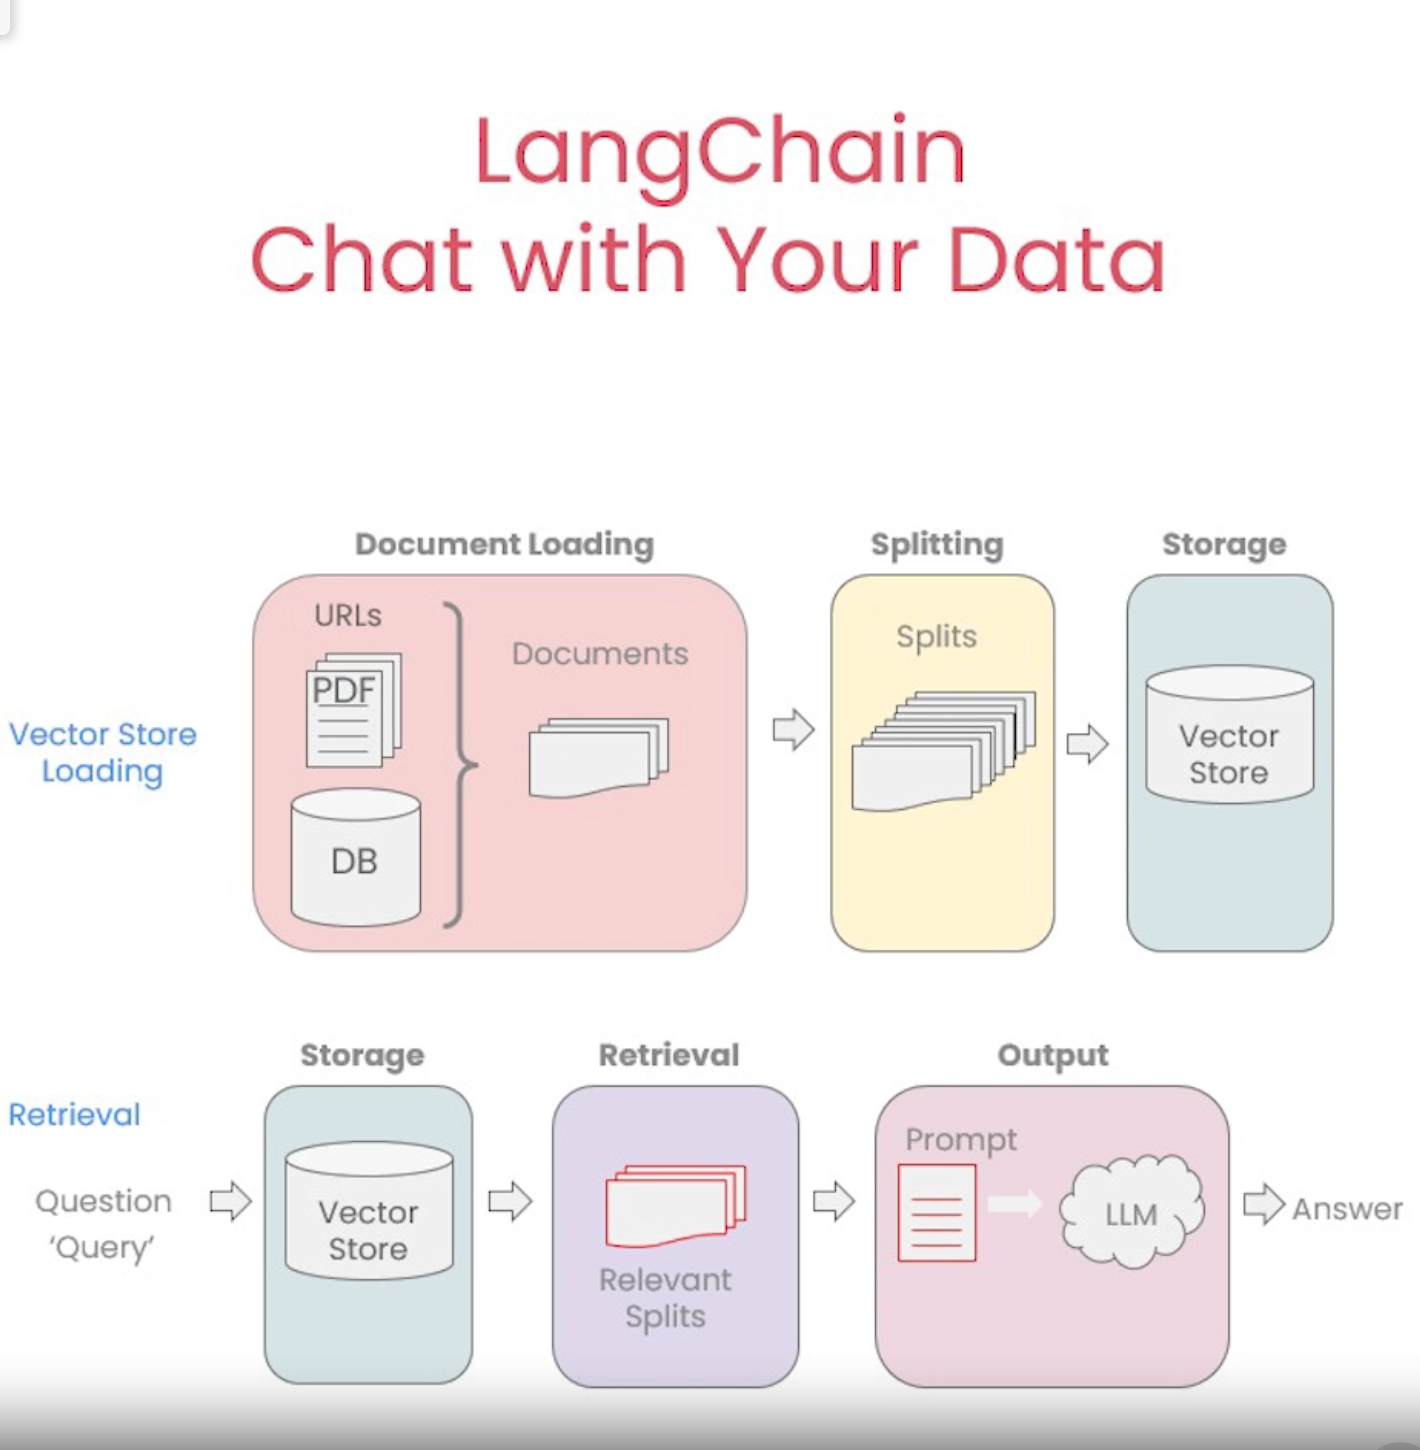

In [ ]:
"""
import os
import openai
import sys
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_type = "azure"
openai.api_base = os.getenv("AZURE_OPENAI_API_BASE")
openai.api_version = "2023-05-15"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.embedding_model = os.getenv("OPENAI_EMBEDDING_MODEL")
embedding_model_deployment = os.getenv("EMBEDDING_MODEL_DEPLOYMENT_NAME")
openai.text_model = os.getenv("OPENAI_TEXT_MODEL")
text_model_deployment = os.getenv("TEXT_MODEL_DEPLOYMENT_NAME")
"""


In [ ]:
"""
from langchain.llms import AzureOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chat_models import AzureChatOpenAI

temprature_default=1.0
temprature_max=2.0
top_p_default=1.0
top_p_max=1.0
max_tokens_default=256
max_tokens_max=4000

def getLLM(temperature=1, top_p=1, max_tokens=256):
    return AzureOpenAI(
    deployment_name=text_model_deployment,
    model_name=openai.text_model,
    openai_api_base=openai.api_base,
    openai_api_key=openai.api_key,
    openai_api_version=openai.api_version,
    openai_api_type= openai.api_type,
    temperature=temperature, top_p=top_p, max_tokens=max_tokens,
    )
def getChatLLM(temperature=1, top_p=1, max_tokens=256):
       return AzureChatOpenAI(
    deployment_name=text_model_deployment,
    model_name=openai.text_model,
    openai_api_base=openai.api_base,
    openai_api_key=openai.api_key,
    openai_api_version=openai.api_version,
    openai_api_type= openai.api_type,
    temperature=temperature, top_p=top_p, max_tokens=max_tokens,
    )

def getEmbeddings():
    return OpenAIEmbeddings(
    deployment=embedding_model_deployment,
    model=openai.embedding_model,
    openai_api_base=openai.api_base,
    openai_api_key=openai.api_key,
    openai_api_type= openai.api_type,
    chunk_size = 16,
    )

"""
